# Understanding RNNs 2

In [293]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [294]:
from fastai.basics import *

In [6]:
!cd jkbc; pip install -e .

Obtaining file:///notebooks/course-v3/kasper/basecaller-p10/jkbc
  Found existing installation: jkbc 0.0.2
    Uninstalling jkbc-0.0.2:
      Successfully uninstalled jkbc-0.0.2
  Running setup.py develop for jkbc


In [295]:
map_t = lambda f, x : torch.tensor(list(map(f, x)))
def convert_to_databunch(x, y, bs, split: float = 0.8):      
    # Get split
    split_train = int(len(x)*split)

    # Split into test/valid sets
    x_train = x[:split_train]
    y_train = y[:split_train]
    x_valid = x[split_train:]
    y_valid = y[split_train:]

    # Create TensorDataset
    ds_train = TensorDataset(x_train, y_train)
    ds_valid = TensorDataset(x_valid, y_valid)

    return DataBunch.create(ds_train, ds_valid, bs=bs)

## Remember 2 steps backwards
x = [c, a, b]

one_hot = [a:0, b:1, c:2]

y = [0, 0, 2] (answers 'c' in one-hot encoding)

In [231]:
N = 120000
seq_len = 3
N2 = N // seq_len
BS = 10000

features_size = 1
hidden_size = 10
high = 10
out_size = high

In [232]:
x = torch.randint(high, (N, seq_len, features_size) ,dtype=torch.float32)

In [233]:
def to_one_hot(num, hot_size:int):
    assert num <= hot_size - 1, "num should be smaller than the hot_size - 1"
    one_hot = [0 for x in range(hot_size)]# torch.zeros((hot_size), dtype=torch.float32)
    one_hot[num] = 1.
    return one_hot

In [234]:
y = torch.tensor(x[:,0,:].clone(), dtype=torch.long).view((N,))
y.shape

/opt/conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


torch.Size([120000])

In [207]:
x[:3], y[:3]

(tensor([[[5.],
          [5.],
          [2.]],
 
         [[3.],
          [3.],
          [6.]],
 
         [[0.],
          [1.],
          [6.]]]), tensor([5, 3, 0]))

In [235]:
data = convert_to_databunch(x, y, BS)

In [236]:
class MyRNN(nn.Module):
    def __init__(self, features, hidden_size, out_size):
        super().__init__()
        self.rnn = nn.RNN(features, hidden_size, batch_first=True)
        self.relu = nn.ReLU()
        self.lin = nn.Linear(hidden_size, out_size)
        self.sm = nn.Softmax(dim=1)
        
    def forward(self, xb):
        out, _ = self.rnn(xb) # BS x seq_len x hidden_size
        out = self.relu(out)
        out = self.lin(out)   # BS x seq_len x out_size
        
        out_last = out[:,-1,:] # BS x 1 x out_size
        
        return self.sm(out_last)

In [237]:
model = MyRNN(features, hidden_size, out_size).cuda()

In [239]:
xb, yb = data.one_batch()
model(xb.cuda()).shape, yb.shape

(torch.Size([10000, 10]), torch.Size([10000]))

In [240]:
learn = Learner(data, model, loss_func=nn.CrossEntropyLoss())

epoch,train_loss,valid_loss,time
0,2.303388,#na#,00:00
1,2.303392,#na#,00:01
2,2.303393,#na#,00:01
3,2.303396,#na#,00:01
4,2.303378,#na#,00:01
5,2.303325,#na#,00:01
6,2.303111,#na#,00:00
7,2.299561,#na#,00:00
8,2.280484,#na#,00:00
9,2.268073,#na#,00:00


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.51E-01
Min loss divided by 10: 3.31E-01


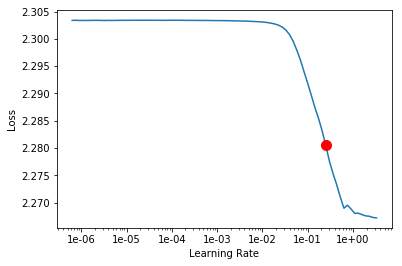

In [241]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [242]:
learn.fit_one_cycle(1000, 1e-02)

epoch,train_loss,valid_loss,time
0,2.303324,2.303153,00:01
1,2.303215,2.303004,00:01
2,2.303107,2.302871,00:01
3,2.303021,2.302736,00:01
4,2.302933,2.302595,00:01
5,2.302827,2.302453,00:01
6,2.302721,2.302298,00:01
7,2.302611,2.302128,00:01
8,2.302489,2.301935,00:01
9,2.302351,2.301716,00:01


KeyboardInterrupt: 

In [243]:
xb, yb = data.one_batch()
xb.shape, yb.shape

(torch.Size([10000, 3, 1]), torch.Size([10000]))

In [266]:
xt = torch.tensor([3., 3, 7, 3]).view((1, 4, 1)).cuda()

In [264]:
yt = model(xt)

In [265]:
yt.argmax()

tensor(9, device='cuda:0')

In [267]:
learn.save("first_in_sequence")

In [300]:
class MyRNN2(nn.Module):
    def __init__(self, features, hidden_size, out_size, num_layers):
        super().__init__()
        self.rnn = nn.RNN(features, hidden_size, num_layers, batch_first=True)
        self.bn = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()
        self.lin = nn.Linear(hidden_size, out_size)
        self.sm = nn.Softmax(dim=1)
        
    def forward(self, xb):
        out, _ = self.rnn(xb) # BS x seq_len x hidden_size
        out = out[:,-1,:] # BS x 1 x out_size
        out = self.bn(out)
        out = self.relu(out)
        out = self.lin(out)
        
        return self.sm(out)

In [301]:
num_layers = 1
hidden_size = 20
model2 = MyRNN2(features, hidden_size, out_size, num_layers).cuda()

In [302]:
learn2 = Learner(data, model2, loss_func=nn.CrossEntropyLoss())

epoch,train_loss,valid_loss,time
0,1.957080,#na#,00:01
1,1.957130,#na#,00:01
2,1.956989,#na#,00:01
3,1.956891,#na#,00:01
4,1.956648,#na#,00:01
5,1.955481,#na#,00:01
6,1.950139,#na#,00:01
7,1.926343,#na#,00:01
8,1.923844,#na#,00:01
9,1.966247,#na#,00:01


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-02
Min loss divided by 10: 1.20E-02


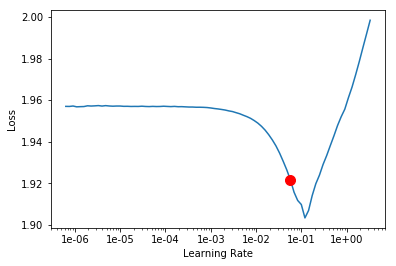

In [305]:
learn2.lr_find()
learn2.recorder.plot(suggestion=True)

In [306]:
learn2.fit_one_cycle(100, 1e-02)

epoch,train_loss,valid_loss,time
0,1.955195,1.963084,00:01
1,1.952969,1.953563,00:01
2,1.950245,1.946498,00:01
3,1.947122,1.939729,00:01
4,1.943271,1.930587,00:01
5,1.938279,1.918692,00:01
6,1.932106,1.906578,00:01
7,1.924503,1.889175,00:01
8,1.914972,1.870406,00:01
9,1.903281,1.844306,00:01


KeyboardInterrupt: 

In [319]:
xt = torch.tensor([[3., 2, 1, 5], [2., 5, 1, 4]]).view((2, 4, 1)).cuda()

In [324]:
with torch.no_grad():
    model.eval()
    y_pred = model2(xt)
    [print(y.argmax()) for y in y_pred]

tensor(3, device='cuda:0')
tensor(6, device='cuda:0')
